In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data
import datetime as dt
from datetime import datetime

# Get Response Data -- SHORTVOL index

Get data from Yahoo since 2008-01-07

In [2]:
# get SHORTVOL data from Yahoo. Thanks for letting me know, Stuart ^_^

svix = data.DataReader('^SHORTVOL', 'yahoo', '1990-01-01')
svix_rets = svix['Adj Close'].pct_change().dropna()
svix_rets = svix_rets['2008-01-07':]
svix_rets.head()

Date
2008-01-07    0.016092
2008-01-08   -0.021566
2008-01-09   -0.003674
2008-01-10    0.037562
2008-01-11   -0.043531
Name: Adj Close, dtype: float64

Get variable data from my dropbox (calculated in R). 

Plot a heatmap of missing variable data. 

Start some imputations.

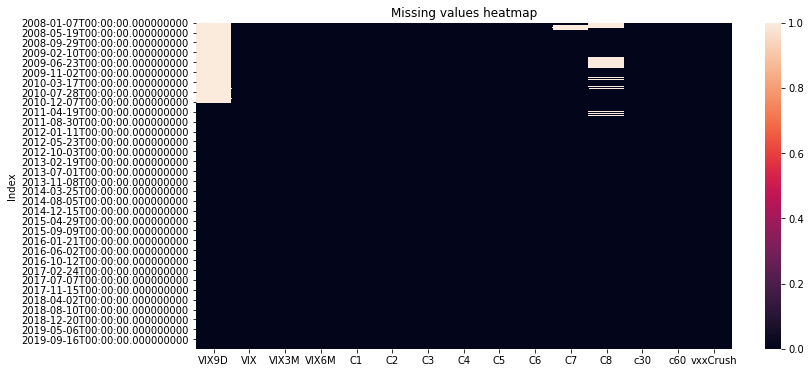

In [3]:
# Get variables from my dropbox. These things are calculated in R because I have my workflow set up in R already. 
# Will have to learn how to dynamically update the dropbox

variables = pd.read_csv("https://www.dropbox.com/s/ykimtkrwpxp80o9/rawVariables.csv?raw=1", parse_dates=True, index_col=0)
variables.head()
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(variables.isnull())
plt.title('Missing values heatmap')
plt.show()

In [4]:

variables['2018-12-04':'2018-12-06']
variables.loc['2018-12-05',['VIX9D', 'VIX', 'VIX3M', 'VIX6M', 'vxxCrush']] = variables.loc['2018-12-04',['VIX9D', 'VIX', 'VIX3M', 'VIX6M', 'vxxCrush']]
variables['2018-12-04':'2018-12-06']

,VIX9D,VIX,VIX3M,VIX6M,C1,C2,C3,C4,C5,C6,C7,C8,c30,c60,vxxCrush
Index,,,,,,,,,,,,,,,
2018-12-04,25.10,20.74,20.75,20.60,19.425,19.275,19.125,19.175,18.975,18.975,18.975,19.100,19.361842,19.353947,-0.328135
2018-12-05,25.10,20.74,20.75,20.60,19.025,19.050,18.975,19.025,18.900,18.900,18.925,19.100,19.036842,19.085526,-0.328135
2018-12-06,25.11,21.19,21.06,20.83,19.925,19.475,19.225,19.275,19.075,19.025,19.025,19.225,19.688158,19.580263,-0.352122


# Initial Feature Engineering -- Contangos and Ratios

Do some feature engineering here. Create the following variables:

M1 roll yield: C1/VIX - 1  
VX30 roll yield: C30 (30 day constant maturity) / VIX - 1  
Contango: C2/C1 - 1  
Adjusted Contango: C60 (60 day constant maturity) / C30 - 1  
M4M7 Contango: C7/C4 - 1  
Fast Cross: VIX9D/VIX  
Medium Cross: VIX/VIX3M  
Slow Cross: VIX/VIX6M  
Strat Cross: VIX3M/VIX6M  

In [5]:
# Do some feature engineering -- roll yields and crossover ratios 
# like the one found in my strategy -- called stratcross here

variables['m1_roll_yield'] = variables['C1']/variables['VIX']-1
variables['VX30_roll_yield'] = variables['c30']/variables['VIX']-1
variables['contango'] = variables['C2']/variables['C1']-1
variables['adj_contango'] = variables['c60']/variables['c30']-1
variables['m4m7_contango'] = variables['C7']/variables['C4']-1
variables['fastcross'] = variables['VIX9D']/variables['VIX']
variables['medcross'] = variables['VIX']/variables['VIX3M']
variables['slowcross'] = variables['VIX']/variables['VIX6M']
variables['stratcross'] = variables['VIX3M']/variables['VIX6M']

# The Response Variable and Variable Histograms

Create the response variable -- sign of the returns of SHORTVOL two days in the future.  
Let's also plot some histograms of some variables, such as the returns, a futures contract, and a contango relationship.

Date
2008-01-07    1
2008-01-08   -1
2008-01-09   -1
2008-01-10    1
2008-01-11   -1
Name: Adj Close, dtype: int64

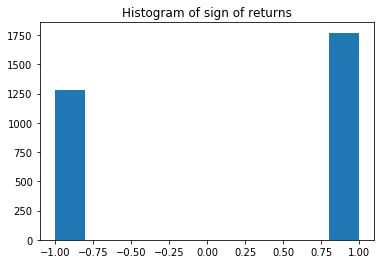

In [6]:
# get the sign of returns

def sign_func(x):
  if x < 0:
    return -1
  if x > 0:
    return 1
  if x == 0:
    return 0

return_sign = svix_rets.apply(sign_func)
plt.hist(return_sign)
plt.title('Histogram of sign of returns')
return_sign.head()


In [7]:
# regression predicted variable -- that is, we predict the value of 2020-01-23
# with the values we see on 2020-01-21
reg_response = svix_rets.shift(-2, axis = 0)

# classification predicted variable -- we'll be using this one
clf_response = return_sign.shift(-2, axis = 0)

reg_response.tail()

# We'll add these later

Date
2020-02-24    0.015858
2020-02-25   -0.137426
2020-02-26   -0.115638
2020-02-27         NaN
2020-02-28         NaN
Name: Adj Close, dtype: float64

C:\Users\Ilya\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Ilya\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


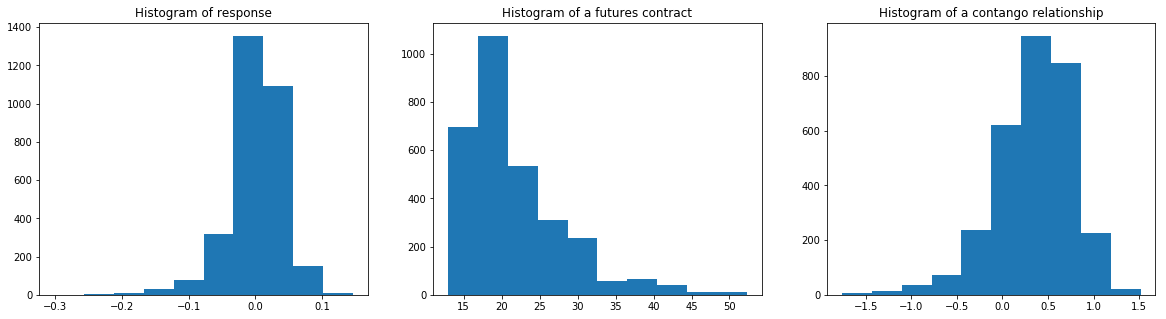

In [8]:
# variables generally are not normal -- the response variable, a contract
# and an example of a contango relationship -- a ratio between two contracts
# log transforms don't really work here due to negative values above -1
# negative values mean boxcox transforms also don't work

plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
plt.hist(reg_response)
plt.title('Histogram of response')
plt.subplot(1, 3, 2)

plt.hist(variables['C4'])
plt.title('Histogram of a futures contract')
plt.subplot(1, 3, 3)
plt.hist(variables['vxxCrush'])
plt.title('Histogram of a contango relationship')
plt.show()
#variables = variables.ffill(axis=1)

# VIX9D Scatterplot

VIX9D starts later than VIX, VIX3M, and VIX6M. We can impute that. Let's look at a scatterplot of values to visualize the relationship.

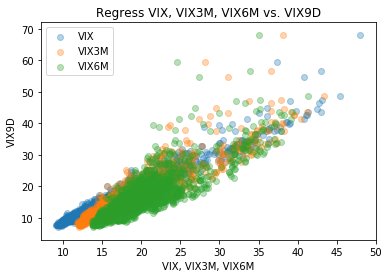

In [9]:
# impute NAs for VIX9D using basic linear regression
# plot relationships between fast and med/slow crosses
plt.scatter(x = variables['VIX'], y = variables['VIX9D'], alpha = .33)
plt.scatter(x = variables['VIX3M'], y = variables['VIX9D'], alpha = .33)
plt.scatter(x = variables['VIX6M'], y = variables['VIX9D'], alpha = .33)
plt.title('Regress VIX, VIX3M, VIX6M vs. VIX9D')
plt.xlabel('VIX, VIX3M, VIX6M')
plt.ylabel('VIX9D')
plt.legend(['VIX', 'VIX3M', 'VIX6M'])

In [10]:

import statsmodels as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

tmp = variables.loc[:,['VIX9D', 'VIX', 'VIX3M', 'VIX6M']]
tmp.head()
X_train = tmp.loc[:,['VIX9D', 'VIX', 'VIX3M', 'VIX6M']].dropna()
y_train = tmp.loc[:,'VIX9D'].dropna()
X_test = tmp.loc[tmp.VIX9D.isnull(),['VIX', 'VIX3M', 'VIX6M']]

del X_train['VIX9D']
# as we can see, there is high correlation between VIX9D vs. VIX/VIX3M/VIX6M. 
# We can run a linear regression model to impute these NA values.

To impute VIX9D, we'll use an elastic net CV linear regression on VIX, VIX3M, and VIX6M.

In [12]:

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
def print_train_stats(X_train, y_train, model):
  model.fit(X_train, y_train)
  y_preds_train = model.predict(X_train)

  print("R-squared of the model in training set is: {}".format(model.score(X_train, y_train)))
  print("Mean absolute error of the prediction in training is: {}".format(mean_absolute_error(y_train, y_preds_train)))
  print("Mean squared error of the prediction in training is: {}".format(mse(y_train, y_preds_train)))
  print("Root mean squared error of the prediction in training is: {}".format(rmse(y_train, y_preds_train)))
  print("Mean absolute percentage error of the prediction in training is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))



In [13]:
elastic_cv = ElasticNetCV(alphas = alphas, cv = 5, max_iter = 10000)
elastic_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(elastic_cv.alpha_))
print_train_stats(X_train, y_train, elastic_cv)

Best alpha value is: 0.01
R-squared of the model in training set is: 0.964917525850025
Mean absolute error of the prediction in training is: 0.8466689538347143
Mean squared error of the prediction in training is: 1.4231719580657474
Root mean squared error of the prediction in training is: 1.1929677104036585
Mean absolute percentage error of the prediction in training is: 5.535521842613312


# Impute VIX9D, C7, C8 contangos

We use elastic net for imputing VIX9D from regressing it on VIX, VIX3M, and VIX6M  
We then create a fastcross variable that is the ratio of VIX9D divided by VIX.  
Lastly, we impute missing values for C7 and C8 by multiplying the last contract before them by the contango relationship between the two contracts previous to them.

In [14]:
# use elastic 

variables.VIX9D[0:754] = elastic_cv.predict(X_test)
variables['fastcross'] = variables['VIX9D']/variables['VIX']
# impute missing C7s with C6 multiplied by C6/C5 contango

variables['C7'][variables.C7.isnull()] = variables['C6'][variables.C7.isnull()] * variables['C6'][variables.C7.isnull()]/ variables['C5'][variables.C7.isnull()]

# repeat for C8
variables['C8'][variables.C8.isnull()] = variables['C7'][variables.C8.isnull()] * variables['C7'][variables.C8.isnull()]/ variables['C6'][variables.C8.isnull()]
variables['m4m7_contango'] = variables['C7']/variables['C4']

In [15]:
variables.head()

,VIX9D,VIX,VIX3M,VIX6M,C1,C2,C3,C4,C5,C6,...,vxxCrush,m1_roll_yield,VX30_roll_yield,contango,adj_contango,m4m7_contango,fastcross,medcross,slowcross,stratcross
Index,,,,,,,,,,,,,,,,,,,,,
2008-01-07,25.607299,23.79,23.22,24.22,24.12,24.81,24.54,24.45,24.37,24.28,...,0.171019,0.013871,0.031596,0.028607,0.017657,0.986912,1.076389,1.024548,0.982246,0.958712
2008-01-08,26.572768,25.43,25.49,25.18,25.54,25.90,25.52,25.35,25.17,25.07,...,0.074774,0.004326,0.013763,0.014096,0.012844,0.980671,1.044938,0.997646,1.009929,1.012311
2008-01-09,24.972582,24.12,24.50,24.48,24.89,25.78,25.28,24.76,24.66,24.49,...,0.318373,0.031924,0.058573,0.035757,0.019474,0.985057,1.035347,0.984490,0.985294,1.000817
2008-01-10,24.272276,23.45,23.95,24.57,24.07,24.95,24.51,24.36,24.27,24.15,...,0.301873,0.026439,0.055627,0.036560,0.015800,0.980296,1.035065,0.979123,0.954416,0.974766
2008-01-11,24.213251,23.68,24.50,24.96,24.96,26.15,26.05,25.92,25.50,25.50,...,0.522062,0.054054,0.095932,0.047676,0.009141,0.974151,1.022519,0.966531,0.948718,0.981571


# New, Unsupervised Material

Use Kmeans and hierarchical clustering to try and find 3 distinct clusters. 
We know that there's a bull market, a bear market, and...whatever's in between.

The challenge is to find the stuff that's in between. Why? Because it's easy to make money trend following when everything's going up...or down.

As the distributions are definitely not normal (not by a long shot), GMMs absolutely do not apply.
Furthermore, as TSNE is just an inferior UMAP, we won't use that.
Also, we know that we are looking for 3 clusters, so DBScan does not apply.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

In [54]:
variables = variables.dropna() 

scaler = StandardScaler() 
scaled_vars = scaler.fit_transform(variables)
scaled_vars
scaled_vars_pd = pd.DataFrame(scaled_vars).dropna()

scaled_vars_pd.tail()

,VIX9D,VIX,VIX3M,VIX6M,C1,C2,C3,C4,C5,C6,...,vxxCrush,m1_roll_yield,VX30_roll_yield,contango,adj_contango,m4m7_contango,fastcross,medcross,slowcross,stratcross
Index,,,,,,,,,,,,,,,,,,,,,
2020-01-15,-0.865168,-0.741185,-0.773535,-0.854960,-0.820306,-0.731267,-0.813094,-0.831955,-0.883363,-0.898249,...,1.081425,-0.073262,1.079228,1.579856,0.691593,0.175329,-2.061873,-0.686448,-0.558709,-0.301367
2020-01-16,-0.863355,-0.751852,-0.795847,-0.882866,-0.861526,-0.764329,-0.841836,-0.862717,-0.915666,-0.931930,...,0.978097,-0.345272,1.044683,1.755381,0.516132,0.245894,-1.974771,-0.643606,-0.531692,-0.297797
2020-01-17,-0.924088,-0.775321,-0.800805,-0.885657,-0.867415,-0.764329,-0.841836,-0.855027,-0.899515,-0.915089,...,1.313252,-0.148701,1.345339,1.820366,0.294819,0.242328,-2.424087,-0.794834,-0.631411,-0.322770
2020-01-21,-0.711976,-0.695315,-0.743786,-0.860541,-0.820306,-0.744492,-0.820280,-0.855027,-0.911629,-0.923509,...,0.811113,-0.547780,0.845411,1.473739,0.024955,0.213847,-0.907874,-0.508083,-0.336285,0.013589
2020-01-22,-0.743702,-0.688914,-0.730151,-0.836821,-0.856227,-0.731267,-0.791538,-0.816574,-0.867212,-0.889828,...,1.214982,-0.933401,0.944598,1.969039,-0.333445,0.056568,-1.249735,-0.535517,-0.373059,-0.041149


In [55]:

kmeans = KMeans(n_clusters = 3, random_state = 123)
kmeans_fits = kmeans.fit_predict(scaled_vars_pd.dropna())

In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn import datasets, metrics


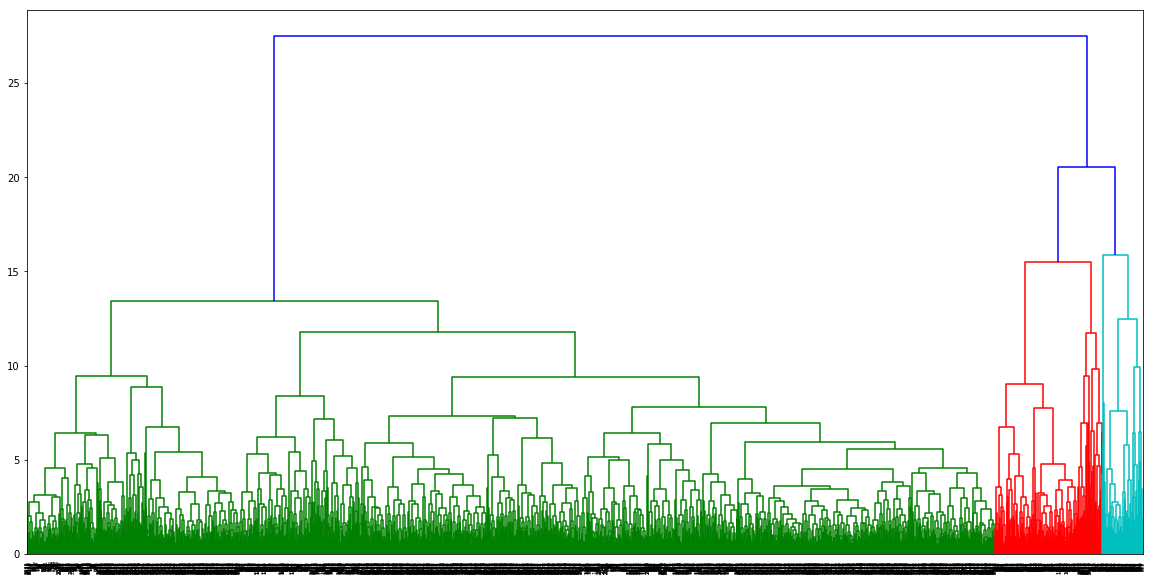

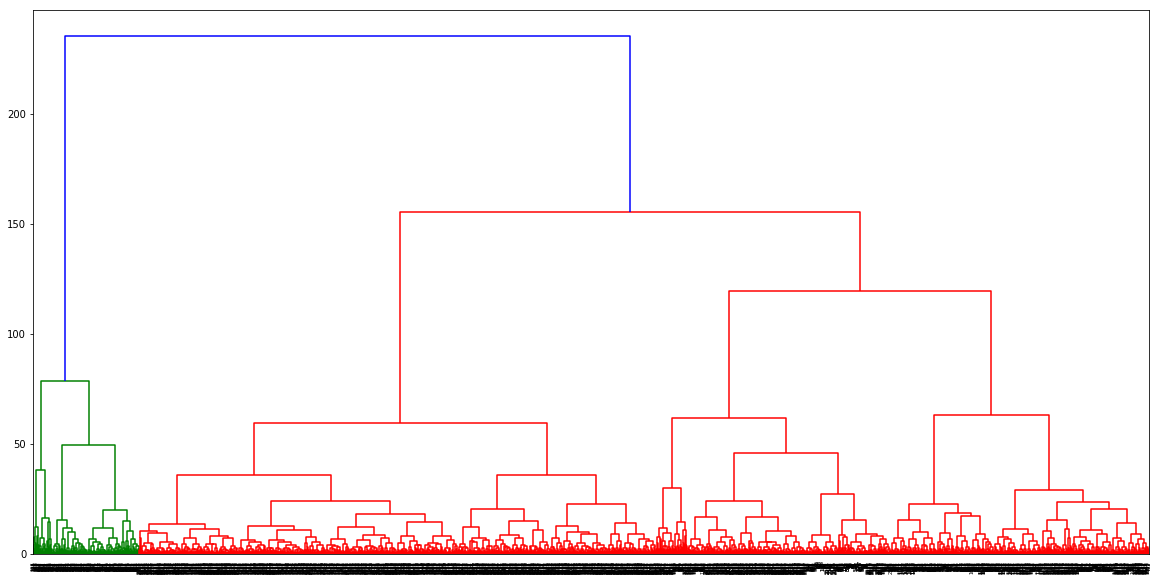

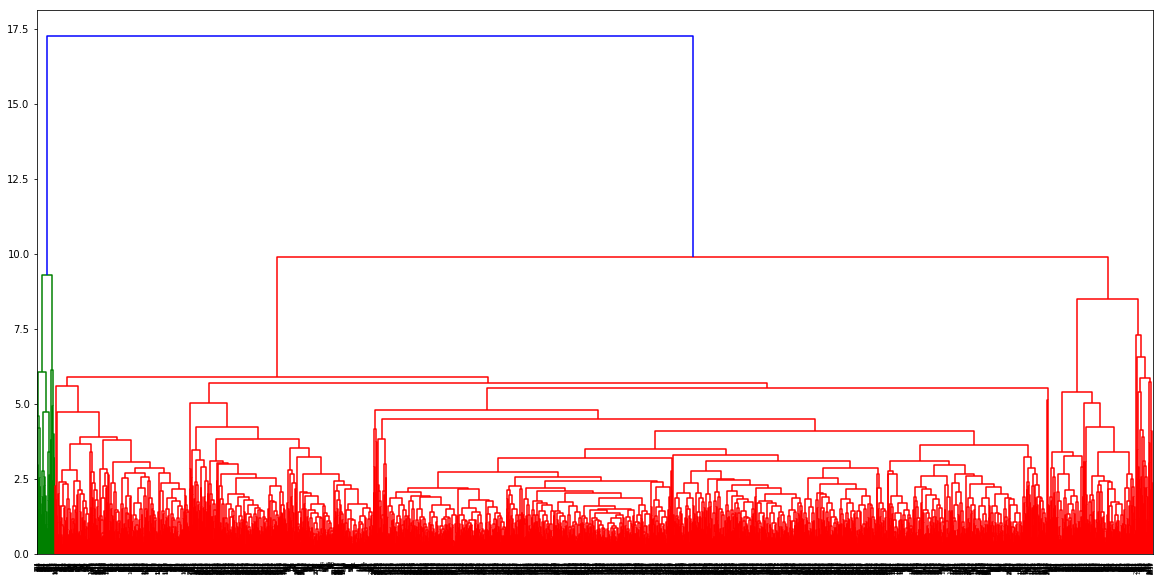

In [43]:
# Highly uneven clusters, these methods probably do not work too well.

plt.figure(figsize=(20,10))
dendrogram(linkage(scaled_vars_pd, method='complete'))
plt.show()
plt.figure(figsize=(20,10))
dendrogram(linkage(scaled_vars_pd, method='ward'))
plt.show()
plt.figure(figsize=(20,10))
dendrogram(linkage(scaled_vars_pd, method='average'))
plt.show()

In [44]:
# Defining the agglomerative clustering
comp_cluster = AgglomerativeClustering(linkage='complete', 
                                       affinity = 'cosine',
                                      n_clusters=3)

# Fit model
comp_clusters = comp_cluster.fit_predict(scaled_vars_pd)

# Defining the agglomerative clustering
ward_cluster = AgglomerativeClustering(linkage='ward',
                                       affinity = 'euclidean',
                                      n_clusters=3)

# Fit model
ward_clusters = ward_cluster.fit_predict(scaled_vars_pd)

# Defining the agglomerative clustering
avg_cluster = AgglomerativeClustering(linkage='average',
                                      affinity = 'cosine',
                                      n_clusters=3)

# Fit model
avg_clusters = avg_cluster.fit_predict(scaled_vars_pd)

In [65]:
y = reg_response[scaled_vars_pd.index]
y_clf = clf_response[scaled_vars_pd.index]
y.tail()


Index
2020-01-15   -0.003415
2020-01-16   -0.009618
2020-01-17   -0.003993
2020-01-21    0.001187
2020-01-22   -0.063023
Name: Adj Close, dtype: float64

In [66]:
print("Adjusted Rand Index of the Complete Agglomerative Clustering 3 solution for return values: {}"
      .format(metrics.adjusted_rand_score(y, comp_clusters)))
print("Adjusted Rand Index of the Complete Agglomerative Clustering 3 solution for sign values: {}"
     .format(metrics.adjusted_rand_score(y_clf, comp_clusters)))
print("The silhoutte score of the Complete Agglomerative Clustering 3 solution: {}"
      .format(metrics.silhouette_score(scaled_vars_pd, comp_clusters, metric='euclidean')))

print("Adjusted Rand Index of the Ward Agglomerative Clustering 3 solution for return values: {}"
      .format(metrics.adjusted_rand_score(y, ward_clusters)))
print("Adjusted Rand Index of the Ward Agglomerative Clustering 3  solution for sign values: {}"
      .format(metrics.adjusted_rand_score(y_clf, ward_clusters)))
print("The silhoutte score of the Ward Agglomerative Clustering 3 solution: {}"
      .format(metrics.silhouette_score(scaled_vars_pd, ward_clusters, metric='euclidean')))

print("Adjusted Rand Index of the Average Agglomerative Clustering 3 solution for return values: {}"
      .format(metrics.adjusted_rand_score(y, avg_clusters)))
print("Adjusted Rand Index of the Average Agglomerative Clustering 3  solution for sign values: {}"
      .format(metrics.adjusted_rand_score(y_clf, avg_clusters)))
print("The silhoutte score of the Average Agglomerative Clustering 3 solution: {}"
      .format(metrics.silhouette_score(scaled_vars_pd, avg_clusters, metric='euclidean')))

print("Adjusted Rand Index of the Kmeans 3 Clustering solution for return values: {}"
      .format(metrics.adjusted_rand_score(y, kmeans_fits)))
print("Adjusted Rand Index of the Kmeans 3 Clustering solution for return sign values: {}"
      .format(metrics.adjusted_rand_score(y_clf, kmeans_fits)))
print("The silhoutte score of the Kmeans 3 Clustering solution: {}"
      .format(metrics.silhouette_score(scaled_vars_pd, kmeans_fits, metric='euclidean')))

Adjusted Rand Index of the Complete Agglomerative Clustering solution for return values: 0.0
Adjusted Rand Index of the Complete Agglomerative Clustering solution for sign values: 0.0010595677176385965
The silhoutte score of the Complete Agglomerative Clustering solution: 0.25426932996798546
Adjusted Rand Index of the Ward Agglomerative Clustering solution for return values: 0.0
Adjusted Rand Index of the Ward Agglomerative Clustering solution for sign values: 0.0022527350722210703
The silhoutte score of the Ward Agglomerative Clustering solution: 0.2848088574186514
Adjusted Rand Index of the Average Agglomerative Clustering solution for return values: 0.0
Adjusted Rand Index of the Average Agglomerative Clustering solution for sign values: 0.0004232004386310067
The silhoutte score of the Average Agglomerative Clustering solution: 0.17715029792192732
Adjusted Rand Index of the Kmeans 3 Clustering solution for return values: 0.0
Adjusted Rand Index of the Kmeans 3 Clustering solution fo

# Dimensionality Reduction With Clustering

From just K-means and agglomerative clustering, the Ward Agglomerative clustering had the highest ARI score on sign values (.002), and Kmeans had the highest silhouette score (.35).

We'll try clustering techniques on PCA and UMAP next.

Use UMAP with parameters of nearest neighbors of 5 - 35, in steps of 5, and components 2-6
Use a kmeans clustering algorithm with 3 clusters on the results
Look at ARI score for return sign values and silhouette scores, since ARI for return values is most likely zero.

In [90]:
import umap

# Using UMAP

neighbors = [5, 10, 15, 20, 25, 30, 35]
components = [2, 3, 4, 5, 6]

k_sil_scores = []
k_ARI_scores = []
w_sil_scores = []
w_ARI_scores = []
for i in neighbors:
    k_component_sil = []
    k_component_ari = []
    w_component_sil = []
    w_component_ari = []
    for j in components:
        
        umap_results = pd.DataFrame(umap.UMAP(n_neighbors = i, n_components = j, min_dist = 0.3,
                                metric = 'correlation').fit_transform(scaled_vars_pd))
        
        # k means and append
        kmeans_umap = kmeans.fit_predict(umap_results)
        k_component_sil.append(metrics.silhouette_score(umap_results, kmeans_umap, metric = 'euclidean'))
        k_component_ari.append(metrics.adjusted_rand_score(y_clf, kmeans_umap))
        
        # ward hierarchical and append
        ward_umap = ward_cluster.fit_predict(umap_results)
        w_component_sil.append(metrics.silhouette_score(umap_results, ward_umap, metric = 'euclidean'))
        w_component_ari.append(metrics.adjusted_rand_score(y_clf, ward_umap))
        
    # bind rows to matrices    
    k_sil_scores.append(k_component_sil)
    k_ARI_scores.append(k_component_ari)
    w_sil_scores.append(w_component_sil)
    w_ARI_scores.append(w_component_ari)
    


C:\Users\Ilya\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
C:\Users\Ilya\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
C:\Users\Ilya\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
C:\Users\Ilya\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
C:\Users\Ilya\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [95]:
k_sil_scores_df = pd.DataFrame(k_sil_scores)
k_ARI_scores_df = pd.DataFrame(k_ARI_scores)
w_sil_scores_df = pd.DataFrame(w_sil_scores)
w_ARI_scores_df = pd.DataFrame(w_ARI_scores)


k_ARI_scores_df.index = k_sil_scores_df.index = w_sil_scores_df.index = w_ARI_scores_df.index = neighbors
k_ARI_scores_df.columns = k_sil_scores_df.columns = w_sil_scores_df.columns = w_ARI_scores_df.columns = components
print(w_ARI_scores_df)
print(k_ARI_scores_df)
print(w_sil_scores_df)
print(k_sil_scores_df)

           2         3         4         5         6
5   0.001764  0.000992  0.001176  0.001295  0.001397
10 -0.000174  0.001792  0.001277  0.000980  0.001599
15  0.000136  0.000070  0.001870  0.001109  0.002006
20  0.000701  0.000640  0.001104  0.001206  0.001669
25  0.001687  0.000443  0.000806  0.000875  0.001468
30  0.000346  0.000691  0.002713  0.000665  0.000842
35  0.000361  0.001074  0.002362  0.001132  0.000626
           2         3         4         5         6
5   0.001708  0.001385  0.001016  0.001067  0.001354
10  0.000821  0.000766  0.001484  0.001912  0.001251
15  0.000762  0.001130  0.001083  0.001148  0.001168
20  0.000677  0.001581  0.001016  0.001431  0.001254
25  0.001272  0.001672  0.001245  0.001782  0.001469
30  0.001220  0.001204  0.001361  0.001591  0.001225
35  0.000916  0.001153  0.001393  0.001353  0.001916
           2         3         4         5         6
5   0.448005  0.418587  0.419291  0.430321  0.427029
10  0.483061  0.466128  0.475936  0.446628  0.

In [96]:
k_sil_scores = []
k_ARI_scores = []
w_sil_scores = []
w_ARI_scores = []

components = [2, 3, 4, 5, 6]
for i in components:
    pca = PCA(n_components = i)
    pca_results = pca.fit_transform(scaled_vars_pd)
    k_pca = kmeans.fit_predict(pca_results)
    w_pca = ward_cluster.fit_predict(pca_results)
    k_sil_scores.append(metrics.silhouette_score(pca_results, k_pca, metric = 'euclidean'))
    w_sil_scores.append(metrics.silhouette_score(pca_results, w_pca, metric = 'euclidean'))
    k_ARI_scores.append(metrics.adjusted_rand_score(y_clf, k_pca))
    w_ARI_scores.append(metrics.adjusted_rand_score(y_clf, w_pca))

    

In [102]:
pca_df = pd.DataFrame([k_sil_scores, w_sil_scores, k_ARI_scores, w_ARI_scores])
pca_df.columns = [2, 3, 4, 5, 6]
pca_df.index = ["Kmeans_PCA_sil", "Ward_PCA_sil", "Kmeans_PCA_ARI", "Ward_PCA_ARI"]
pca_df

,2,3,4,5,6
Kmeans_PCA_sil,0.429035,0.396447,0.378062,0.365913,0.357494
Ward_PCA_sil,0.362719,0.282536,0.318818,0.317109,0.274166
Kmeans_PCA_ARI,0.001352,0.001401,0.000983,0.000983,0.000974
Ward_PCA_ARI,0.002029,0.002874,0.001929,0.003238,0.001249


# Visualization

We have two clustering procedures -- the best ARI score -- PCA 5 ward clustering (with 3 clusters), and best silhouette score -- 2 component UMAP with 10 nearest neighbors, with K = 3 clusters.

In [107]:
umap_results = pd.DataFrame(umap.UMAP(n_neighbors = 10, n_components = 2, min_dist = 0.3,
                                metric = 'correlation').fit_transform(scaled_vars_pd))
        
# k means
kmeans_umap = kmeans.fit_predict(umap_results)

pca = PCA(n_components = 5)
pca_results = pca.fit_transform(scaled_vars_pd)
w_pca = ward_cluster.fit_predict(pca_results)

In [181]:
np.unique(kmeans_umap)
np.unique(w_pca)

km_dummies = pd.get_dummies(kmeans_umap)
km_dummies.index = y.index

w_dummies = pd.get_dummies(w_pca)
w_dummies.index = y.index


y3 = pd.concat([y, y, y], axis = 1)

km_dummies.columns = w_dummies.columns = ['c1', 'c2', 'c3']

def annualized_returns(r, periodsInYear = 252):
    return ((1+r).prod()**(periodsInYear/r.shape[0])-1)

def annualized_vol(r, periodsInYear = 252):
    return r.std(ddof=0)*np.sqrt(periodsInYear)

def drawdown(return_series: pd.Series):
    """
    Computes wealth index, drawdowns/max DDs for a time series
    """
    wealth_idx = (1+return_series).cumprod()
    previous_peaks = wealth_idx.cummax()
    drawdown = (wealth_idx-previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_idx,
        "Peaks": previous_peaks,
        "Drawdown": drawdown
    })


km_umap_c1 = km_dummies['c1'] * y
km_umap_c2 = km_dummies['c2'] * y
km_umap_c3 = km_dummies['c3'] * y

w_pca_c1 = w_dummies['c1'] * y
w_pca_c2 = w_dummies['c2'] * y
w_pca_c3 = w_dummies['c3'] * y


print(annualized_returns(km_c1))
print(annualized_returns(km_c2))
print(annualized_returns(km_c3))


print(annualized_returns(w_pca_c1))
print(annualized_returns(w_pca_c2))
print(annualized_returns(w_pca_c3))




0.12543835806984438
-0.06803094389942743
0.23265702197245353
0.27905113597765085
-0.11330755422866556
0.1399991924638928


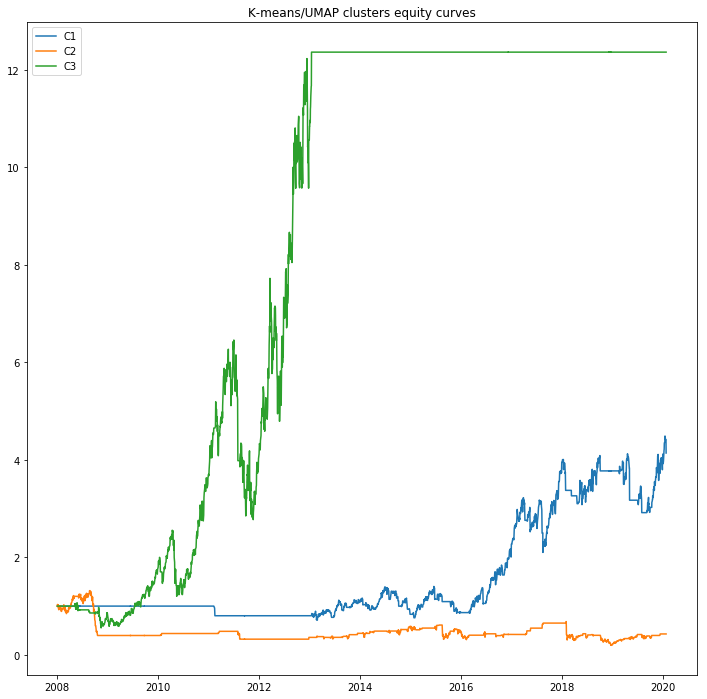

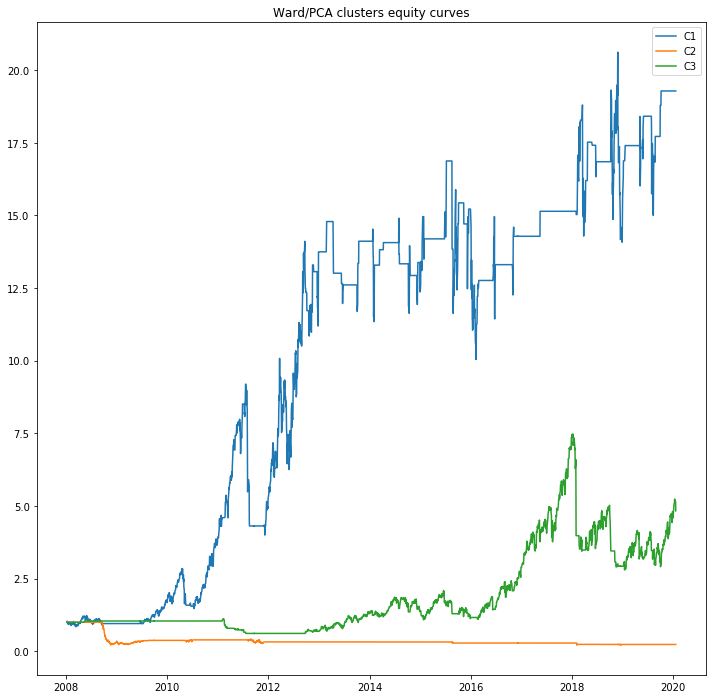

,C1,C2,C3
Index,,,
2008-01-07,1.0,0.996326,1.0
2008-01-08,1.0,1.033750,1.0
2008-01-09,1.0,0.988750,1.0
2008-01-10,1.0,1.021352,1.0
2008-01-11,1.0,1.011250,1.0


In [190]:
plt.figure(figsize=(12, 12))
km_wealth = pd.DataFrame(pd.concat([drawdown(km_umap_c1)['Wealth'], drawdown(km_umap_c2)['Wealth'], drawdown(km_umap_c3)['Wealth']], axis = 1))
km_wealth.columns = ['C1', 'C2', 'C3']
plt.plot(km_wealth)
plt.title("K-means/UMAP clusters equity curves")
plt.legend(['C1', 'C2', 'C3'])
plt.show()

plt.figure(figsize=(12, 12))
wp_wealth = pd.DataFrame(pd.concat([drawdown(w_pca_c1)['Wealth'], drawdown(w_pca_c2)['Wealth'], drawdown(w_pca_c3)['Wealth']], axis = 1))
wp_wealth.columns = ['C1', 'C2', 'C3']
plt.plot(wp_wealth)
plt.title("Ward/PCA clusters equity curves")
plt.legend(['C1', 'C2', 'C3'])
plt.show()

km_wealth.head()

# Conclusions

While the clustering doesn't simply lose money no matter what, the results still aren't as satisfactory as I'd like.
The UMAP/Kmeans simply says that the top cluster stopped in 2014, and we definitely had good short vol opportunities past that (such as in 2017). 

Meanwhile, the middle cluster sees all of 2017 in that middle cluster (AKA stay on the sidelines). This is definitely incorrect. 

Lastly, while the bottom cluster correctly identifies the financial crisis as uniquely bad, there were other times to make money in long volatility that it doesn't pick up.

Furthermore, this is all with the benfit of hindsight. Certainly, I would not trade on either of these clustering segmentations.

Frustrating aspect is the temporal inconsistency. EG the ward/PCA C1 skyrockets until 2013 and then becomes inconsistent, while C3 simply has all of 2017 under its umbrella.

There may be a way to fine-tune the clustering in the future depending on the exact nature of the features fed to it, but that will do it for this project.